# Data Science Bowl 2018 Exploration

In [1]:
import keras.backend as K
from matplotlib import pyplot as plt
from skimage.io import imshow, imread_collection
from skimage.transform import resize
from PIL import Image as pil_image
from utils import *
from fastai import *
import os
from imageio import imread
from collections import Counter
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = os.curdir + '/data/'
trn_path = path + 'train/'
tst_path = path + 'test1/'

if os.path.exists(path+'models/')==False:
    os.mkdir(path+'models/')
if os.path.exists(path+'results/')==False:
    os.mkdir(path+'results/')

In [3]:
train_ids = next(os.walk(trn_path))[1]
test_ids = next(os.walk(tst_path))[1]

In [24]:
tp = trn_path+train_ids[0]+'/images/'+train_ids[0]+'.png'

In [26]:
timg = imread(tp)[:,:,:3]

In [27]:
timg.shape

(256, 256, 3)

In [28]:
msk = imread_collection(trn_path+train_ids[0]+'/masks/*.png')

In [30]:
msk = msk.concatenate()

In [31]:
msk.shape

(60, 256, 256)

In [22]:
msk = np.rollaxis(msk,0,3)

In [46]:
def make_data_array(path, data_ids, get_masks=False):
    imgs=[]
    msks=[]
    img_sizes=[]
    for id_ in data_ids:
        img = pil_image.open(path+id_+'/images/'+id_+'.png')
        img = img.convert(mode='RGB')
        img_sizes.append(img.size)
        #height, width = img.size
        img = img.resize((256,256))
        img = np.asarray(img)
        imgs.append(img)
        
        if get_masks:
            msk = imread_collection(path+id_+'/masks/*.png').concatenate()
            num_masks = msk.shape[0]
            #essentially makes an empty image that's all black
            labels = np.zeros(msk.shape[1:], np.uint16)
            #for each pixel in a mask that is > 0 it adds that pixel to black image, 
            #color is incremented by 1 to discern individual cells
            for idx in range(num_masks):
                labels[msk[idx] > 0] = idx + 1
            labels = pil_image.fromarray(labels)
            labels = labels.resize((256,256))
            msk = np.expand_dims(np.asarray(labels), axis=2)
            msks.append(msk)
    if get_masks:
        return imgs, msks, img_sizes
    else:
        return imgs, img_sizes

In [7]:
trn_imgs, trn_msks, trn_sizes = make_data_array(trn_path, train_ids, get_masks=True)
tst_imgs, tst_sizes = make_data_array(tst_path, test_ids)

In [6]:
#save_array(path+'trn_imgs.bc', trn_imgs)
#save_array(path+'trn_msks.bc', trn_msks)
#save_array(path+'trn_sizes.bc', trn_sizes)
#save_array(path+'tst_imgs.bc', tst_imgs)
#save_array(path+'tst_sizes.bc', tst_sizes)

In [32]:
trn_imgs = load_array(path+'trn_imgs.bc')
trn_msks = load_array(path+'trn_msks.bc')
trn_sizes = load_array(path+'trn_sizes.bc')
tst_imgs = load_array(path+'tst_imgs.bc')
tst_sizes = load_array(path+'tst_sizes.bc')

In [37]:
Counter(trn_sizes[:,0]) #widths

Counter({256: 334,
         320: 112,
         347: 5,
         360: 91,
         640: 13,
         696: 92,
         1024: 16,
         1272: 6,
         1388: 1})

In [38]:
Counter(trn_sizes[:,1]) #heights

Counter({256: 446,
         260: 5,
         360: 91,
         512: 13,
         520: 92,
         603: 6,
         1024: 16,
         1040: 1})

## Data Augmentation

After the disaster that occurred last time when using data augmentation, I want to make sure that this works correctly and produce the kinds of images that I would expect. It's also essential that the mask layer perfectly matches the transformed image or I'm out of business.

In [13]:
gen = ImageDataGenerator()

In [14]:
img_aug = gen.flow(trn_imgs, batch_size=1, shuffle=False, seed=1337)
msk_aug = gen.flow(trn_msks, batch_size=1, shuffle=False, seed=1337)

In [15]:
#this seems to work pretty well for training at least, I'll probably need to dig up that train_on_batch function again
#or just precompute augmentation
images=[]
masks=[]
for x in range(len(trn_imgs)):
    images.append(next(img_aug)[0])
    masks.append(next(msk_aug)[0].squeeze())

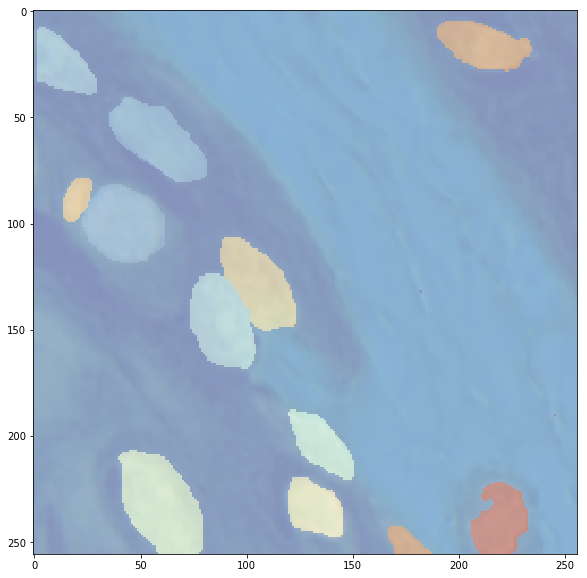

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(masks[44], cmap='coolwarm', alpha=0.5)
plt.imshow(images[44], alpha=0.2)

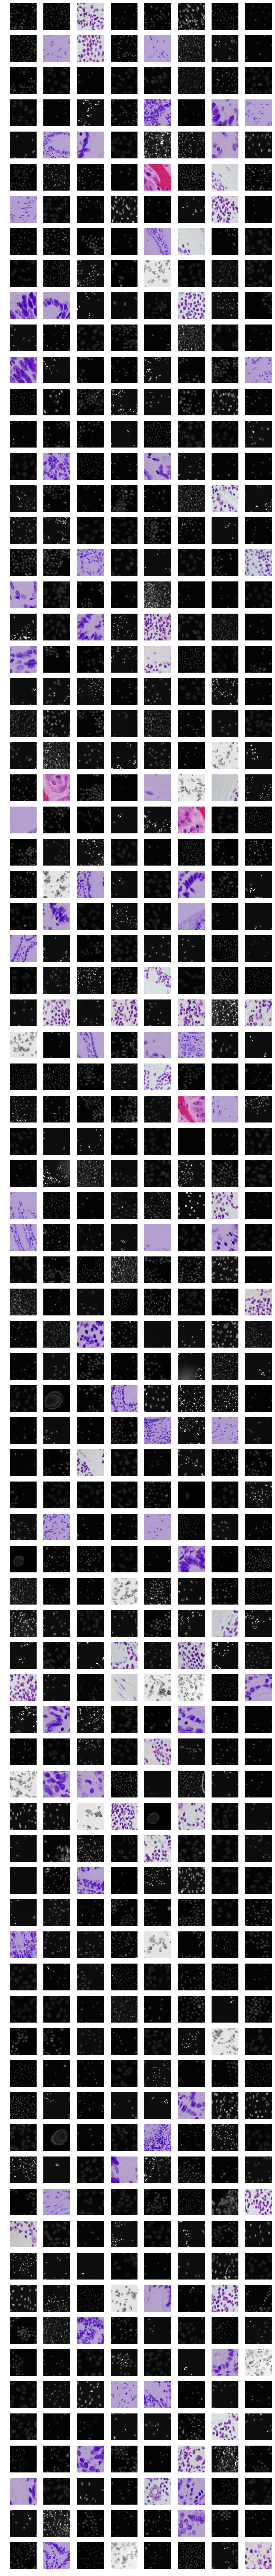

In [18]:
#almost all the training images
plot_images(trn_imgs, 80, 8)

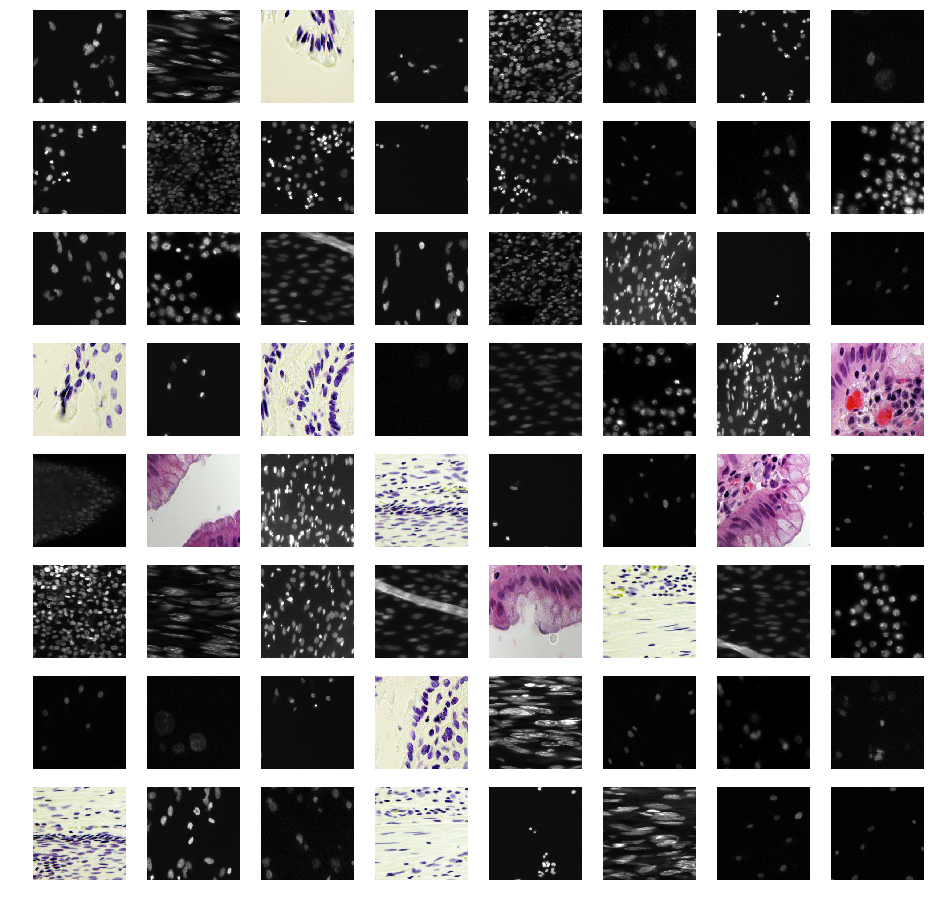

In [19]:
#almost all the test images
plot_images(tst_imgs, 8, 8)

## Metric Validation

Before going to much further I want to make sure that I understand how the evaluation metric will actually work and figure out if there's any loss when I upsample the resized masks.

Essentially, I want to convert the mask back to the original size and then evaluate the mean average precision (map) to make sure it's 1. If not, then I know that the downsampling and upsampling automatically leads to losses. This is really just a sanity check. If the metric is setup correctly I shouldn't have any issues

In [11]:
#takes neighboring pixels with the same value and assigns them to the same label
from skimage.morphology import label

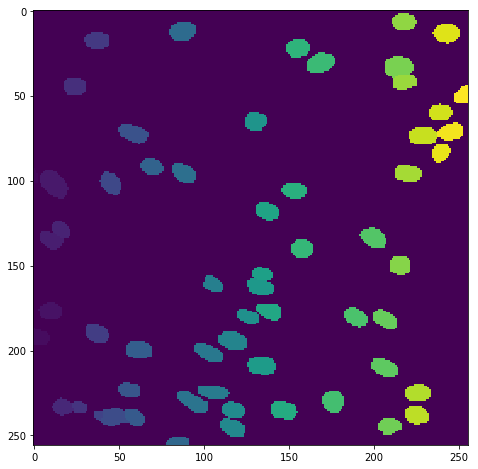

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(label(trn_msks[0]).squeeze())

## Image Clustering